<a href="https://colab.research.google.com/github/pietroduke/plant-identification-forest/blob/main/icce_inceptionv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns
from typing import Dict, List, Optional, Callable
import json

In [14]:
vit_models = timm.list_models('*inception*')
print(vit_models)

['inception_next_atto', 'inception_next_base', 'inception_next_small', 'inception_next_tiny', 'inception_resnet_v2', 'inception_v3', 'inception_v4']


In [4]:
!unzip  /content/drive/MyDrive/PlantIdentification/Single.zip

Streaming output truncated to the last 5000 lines.
  inflating: Single/train/Đa/crop_327_patch17.png  
Single/train/Đa/crop_327_patch18.png:  mismatching "local" filename (Single/train/─Рa/crop_327_patch18.png),
         continuing with "central" filename version
  inflating: Single/train/Đa/crop_327_patch18.png  
Single/train/Đa/crop_327_patch19.png:  mismatching "local" filename (Single/train/─Рa/crop_327_patch19.png),
         continuing with "central" filename version
  inflating: Single/train/Đa/crop_327_patch19.png  
Single/train/Đa/crop_327_patch2.png:  mismatching "local" filename (Single/train/─Рa/crop_327_patch2.png),
         continuing with "central" filename version
  inflating: Single/train/Đa/crop_327_patch2.png  
Single/train/Đa/crop_327_patch20.png:  mismatching "local" filename (Single/train/─Рa/crop_327_patch20.png),
         continuing with "central" filename version
  inflating: Single/train/Đa/crop_327_patch20.png  
Single/train/Đa/crop_327_patch21.png:  mismatchi

In [15]:
!rm -rf "/content/Single/test/Bời Lời"
!rm -rf "/content/Single/test/Lim xanh"
!rm -rf "/content/Single/test/Sếu"
!rm -rf "/content/Single/test/Lòng Mang"
!rm -rf "/content/Single/test/Chẹo"
!rm -rf "/content/Single/test/Mé Cò Ke"
!rm -rf "/content/Single/test/Dẻ cau"
!rm -rf "/content/Single/test/Nanh Chuột"
!rm -rf "/content/Single/test/Thôi Ba"
!rm -rf "/content/Single/test/Bời Lời Lá Tròn"
!rm -rf "/content/Single/test/Sồi Xanh"
!rm -rf "/content/Single/test/Lim Xẹt"

!rm -rf "/content/Single/train/Bời Lời"
!rm -rf "/content/Single/train/Lim xanh"
!rm -rf "/content/Single/train/Sếu"
!rm -rf "/content/Single/train/Lòng Mang"
!rm -rf "/content/Single/train/Chẹo"
!rm -rf "/content/Single/train/Mé Cò Ke"
!rm -rf "/content/Single/train/Dẻ cau"
!rm -rf "/content/Single/train/Nanh Chuột"
!rm -rf "/content/Single/train/Thôi Ba"
!rm -rf "/content/Single/train/Bời Lời Lá Tròn"
!rm -rf "/content/Single/train/Sồi Xanh"
!rm -rf "/content/Single/train/Lim Xẹt"

!rm -rf "/content/Single/val/Bời Lời"
!rm -rf "/content/Single/val/Lim xanh"
!rm -rf "/content/Single/val/Sếu"
!rm -rf "/content/Single/val/Lòng Mang"
!rm -rf "/content/Single/val/Chẹo"
!rm -rf "/content/Single/val/Mé Cò Ke"
!rm -rf "/content/Single/val/Dẻ cau"
!rm -rf "/content/Single/val/Nanh Chuột"
!rm -rf "/content/Single/val/Thôi Ba"
!rm -rf "/content/Single/val/Bời Lời Lá Tròn"
!rm -rf "/content/Single/val/Sồi Xanh"
!rm -rf "/content/Single/val/Lim Xẹt"

In [16]:
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [17]:
# class EarlyStopping:
#     """Early stopping callback"""
#     def __init__(self, patience=7, min_delta=0, mode='max'):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.mode = mode
#         self.counter = 0
#         self.best_score = None
#         self.early_stop = False

#     def __call__(self, score):
#         if self.best_score is None:
#             self.best_score = score
#         elif self.mode == 'max':
#             if score < self.best_score + self.min_delta:
#                 self.counter += 1
#                 if self.counter >= self.patience:
#                     self.early_stop = True
#             else:
#                 self.best_score = score
#                 self.counter = 0
#         else:  # mode == 'min'
#             if score > self.best_score - self.min_delta:
#                 self.counter += 1
#                 if self.counter >= self.patience:
#                     self.early_stop = True
#             else:
#                 self.best_score = score
#                 self.counter = 0

#         return self.early_stop

# class ModelCheckpoint:
#     """Model checkpoint callback"""
#     def __init__(self, filepath, monitor='val_loss', mode='min', save_best_only=True):
#         self.filepath = filepath
#         self.monitor = monitor
#         self.mode = mode
#         self.save_best_only = save_best_only
#         self.best_score = None

#     def __call__(self, model, optimizer, epoch, metrics):
#         score = metrics.get(self.monitor)

#         if not self.save_best_only:
#             self._save_model(model, optimizer, epoch, metrics)
#             return False

#         if self.best_score is None:
#             self.best_score = score
#             self._save_model(model, optimizer, epoch, metrics)
#             return True

#         improved = False
#         if self.mode == 'max' and score > self.best_score:
#             self.best_score = score
#             self._save_model(model, optimizer, epoch, metrics)
#             improved = True
#         elif self.mode == 'min' and score < self.best_score:
#             self.best_score = score
#             self._save_model(model, optimizer, epoch, metrics)
#             improved = True

#         return improved

#     def _save_model(self, model, optimizer, epoch, metrics):
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'metrics': metrics
#         }, self.filepath)

# class ReduceLROnPlateau:
#     """Reduce learning rate when a metric has stopped improving"""
#     def __init__(self, optimizer, monitor='val_loss', mode='min', factor=0.5,
#                  patience=5, min_lr=1e-6, verbose=1):
#         self.optimizer = optimizer
#         self.monitor = monitor
#         self.mode = mode
#         self.factor = factor
#         self.patience = patience
#         self.min_lr = min_lr
#         self.verbose = verbose

#         self.best_score = None
#         self.counter = 0
#         self.current_lr = optimizer.param_groups[0]['lr']

#     def __call__(self, metrics):
#         score = metrics.get(self.monitor)

#         if self.best_score is None:
#             self.best_score = score
#             return

#         improved = False
#         if self.mode == 'min':
#             improved = score < self.best_score
#         else:  # mode == 'max'
#             improved = score > self.best_score

#         if improved:
#             self.best_score = score
#             self.counter = 0
#         else:
#             self.counter += 1

#             if self.counter >= self.patience:
#                 old_lr = self.current_lr
#                 new_lr = max(old_lr * self.factor, self.min_lr)

#                 if new_lr < old_lr:
#                     for param_group in self.optimizer.param_groups:
#                         param_group['lr'] = new_lr
#                     self.current_lr = new_lr
#                     self.counter = 0

#                     if self.verbose:
#                         print(f"\n📉 ReduceLROnPlateau: reducing learning rate from {old_lr:.6f} to {new_lr:.6f}")

# class LearningRateSchedulerCallback:
#     """Learning rate scheduler callback with warmup"""
#     def __init__(self, optimizer, warmup_epochs=5, min_lr=1e-6):
#         self.optimizer = optimizer
#         self.warmup_epochs = warmup_epochs
#         self.min_lr = min_lr
#         self.initial_lr = optimizer.param_groups[0]['lr']

#     def on_epoch_end(self, epoch, scheduler):
#         if epoch < self.warmup_epochs:
#             # Warmup phase
#             lr = self.initial_lr * (epoch + 1) / self.warmup_epochs
#             for param_group in self.optimizer.param_groups:
#                 param_group['lr'] = lr
#         else:
#             # Normal scheduling
#             scheduler.step()

In [18]:
class EarlyStopping:
    """Early stopping callback - dùng val_acc"""
    def __init__(self, patience=7, min_delta=0, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif self.mode == 'max':
            if score < self.best_score + self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0
        else:  # mode == 'min'
            if score > self.best_score - self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0

        return self.early_stop


class ModelCheckpoint:
    """Model checkpoint callback - dùng val_acc"""
    def __init__(self, filepath, monitor='val_acc', mode='max', save_best_only=True):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.best_score = None

    def __call__(self, model, optimizer, epoch, metrics):
        score = metrics.get(self.monitor)

        if not self.save_best_only:
            self._save_model(model, optimizer, epoch, metrics)
            return False

        if self.best_score is None:
            self.best_score = score
            self._save_model(model, optimizer, epoch, metrics)
            return True

        improved = False
        if self.mode == 'max' and score > self.best_score:
            self.best_score = score
            self._save_model(model, optimizer, epoch, metrics)
            improved = True
        elif self.mode == 'min' and score < self.best_score:
            self.best_score = score
            self._save_model(model, optimizer, epoch, metrics)
            improved = True

        return improved

    def _save_model(self, model, optimizer, epoch, metrics):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'metrics': metrics
        }, self.filepath)


class ReduceLROnPlateau:
    """Reduce learning rate when accuracy has stopped improving"""
    def __init__(self, optimizer, monitor='val_acc', mode='max', factor=0.5,
                 patience=5, min_lr=1e-6, verbose=1):
        self.optimizer = optimizer
        self.monitor = monitor
        self.mode = mode
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose

        self.best_score = None
        self.counter = 0
        self.current_lr = optimizer.param_groups[0]['lr']

    def __call__(self, metrics):
        score = metrics.get(self.monitor)

        if self.best_score is None:
            self.best_score = score
            return

        improved = False
        if self.mode == 'min':
            improved = score < self.best_score
        else:  # mode == 'max'
            improved = score > self.best_score

        if improved:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1

            if self.counter >= self.patience:
                old_lr = self.current_lr
                new_lr = max(old_lr * self.factor, self.min_lr)

                if new_lr < old_lr:
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = new_lr
                    self.current_lr = new_lr
                    self.counter = 0

                    if self.verbose:
                        print(f"\n📉 ReduceLROnPlateau: reducing learning rate from {old_lr:.6f} to {new_lr:.6f}")


class LearningRateSchedulerCallback:
    """Learning rate scheduler callback with warmup"""
    def __init__(self, optimizer, warmup_epochs=5, min_lr=1e-6):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.min_lr = min_lr
        self.initial_lr = optimizer.param_groups[0]['lr']

    def on_epoch_end(self, epoch, scheduler):
        if epoch < self.warmup_epochs:
            # Warmup phase
            lr = self.initial_lr * (epoch + 1) / self.warmup_epochs
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        else:
            # Normal scheduling
            scheduler.step()


In [19]:
class ModelTrainer:
    def __init__(self, train_dir, val_dir, test_dir, model_name='inception_v4',
                 img_size=224, batch_size=32, lr=3e-5, epochs=50,
                 use_focal_loss=False, focal_alpha=1, focal_gamma=2,
                 device=None):
        """
        Init Enhanced Trainer

        Args:
            train_dir: Path to train directory
            val_dir: Path to validation directory
            test_dir: Path to test directory
            model_name: Model name from timm
            img_size: Image size
            batch_size: Batch size
            lr: Learning rate
            epochs: Number of epochs
            use_focal_loss: Whether to use Focal Loss
            focal_alpha: Focal Loss alpha parameter
            focal_gamma: Focal Loss gamma parameter
            device: Device (cuda/cpu)
        """
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir
        self.model_name = model_name
        self.img_size = img_size
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.use_focal_loss = use_focal_loss
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.val_precisions = []
        self.val_recalls = []
        self.val_f1s = []
        self.learning_rates = []

        # Callbacks
        self.callbacks = []

        self._setup_data()
        self._setup_model(focal_alpha, focal_gamma)
        self._setup_optimizer()

    def _setup_data(self):
        """Setup DataLoader"""
        train_transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),

            # 🔹 Thay đổi màu sắc / ánh sáng
            transforms.ColorJitter(
                brightness=0.2,   # ±20% độ sáng
                contrast=0.2,     # ±20% độ tương phản
                saturation=0.2,   # ±20% độ bão hòa
                hue=0.05          # lệch màu nhẹ
            ),

            # 🔹 Sắc nét / mờ
            transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),

            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        test_transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        # Create datasets
        self.train_dataset = datasets.ImageFolder(self.train_dir, transform=train_transform)
        self.val_dataset = datasets.ImageFolder(self.val_dir, transform=test_transform)
        self.test_dataset = datasets.ImageFolder(self.test_dir, transform=test_transform)

        # Create data loaders
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )

        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )

        self.test_loader = DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )

        self.num_classes = len(self.train_dataset.classes)
        self.class_names = self.train_dataset.classes

        print(f"Number of classes: {self.num_classes}")
        print(f"Class names: {self.class_names}")
        print(f"Number of train images: {len(self.train_dataset)}")
        print(f"Number of validation images: {len(self.val_dataset)}")
        print(f"Number of test images: {len(self.test_dataset)}")

    def _setup_model(self, focal_alpha, focal_gamma):
        """Setup model and loss function"""
        self.model = timm.create_model(
            self.model_name,
            pretrained=True,
            num_classes=self.num_classes
        )
        self.model = self.model.to(self.device)

        # Choose loss function
        if self.use_focal_loss:
            self.criterion = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
            print(f"Using Focal Loss (alpha={focal_alpha}, gamma={focal_gamma})")
        else:
            self.criterion = nn.CrossEntropyLoss()
            print("Using CrossEntropy Loss")

        print(f"Model: {self.model_name}")
        print(f"Device: {self.device}")
        print(f"Number of parameters: {sum(p.numel() for p in self.model.parameters()):,}")

    def _setup_optimizer(self):
        """Setup optimizer and scheduler"""
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=0.05
        )

        # self.optimizer = optim.SGD(
        #     self.model.parameters(),
        #     lr=self.lr,
        #     momentum=0.9,
        #     weight_decay=1e-4
        # )

        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=self.epochs
        )

    def add_callback(self, callback):
        """Add a callback"""
        self.callbacks.append(callback)

    def train_epoch(self):
        """Training for 1 epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc="Training")
        for images, labels in pbar:
            images, labels = images.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc

    def validate_epoch(self, data_loader, desc="Validation"):
        """Validation/Test for 1 epoch"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_predicted = []
        all_labels = []

        with torch.no_grad():
            pbar = tqdm(data_loader, desc=desc)
            for images, labels in pbar:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predicted.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*correct/total:.2f}%'
                })

        epoch_loss = running_loss / len(data_loader)
        epoch_acc = 100. * correct / total

        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_predicted, average='macro', zero_division=0
        )

        return epoch_loss, epoch_acc, precision*100, recall*100, f1*100, all_predicted, all_labels

    def train(self):
        """Training model"""
        print("Start training...")
        print("="*50)

        for epoch in range(self.epochs):
            start_time = time.time()

            # Training
            train_loss, train_acc = self.train_epoch()

            # Validation
            val_loss, val_acc, val_precision, val_recall, val_f1, _, _ = self.validate_epoch(
                self.val_loader, "Validation"
            )

            # Get current learning rate
            current_lr = self.optimizer.param_groups[0]['lr']

            # Save history
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accs.append(train_acc)
            self.val_accs.append(val_acc)
            self.val_precisions.append(val_precision)
            self.val_recalls.append(val_recall)
            self.val_f1s.append(val_f1)
            self.learning_rates.append(current_lr)

            # Prepare metrics for callbacks
            metrics = {
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'val_precision': val_precision,
                'val_recall': val_recall,
                'val_f1': val_f1
            }

            # Execute callbacks
            should_stop = False
            for callback in self.callbacks:
                if isinstance(callback, EarlyStopping):
                    if callback(val_loss):
                        print(f"🛑 Early stopping triggered at epoch {epoch+1}")
                        should_stop = True
                        break
                elif isinstance(callback, ModelCheckpoint):
                    if callback(self.model, self.optimizer, epoch, metrics):
                        print(f"💾 Saved best model at epoch {epoch+1}")
                elif isinstance(callback, ReduceLROnPlateau):
                    callback(metrics)
                elif isinstance(callback, LearningRateSchedulerCallback):
                    callback.on_epoch_end(epoch, self.scheduler)

            # Update scheduler if not using custom callback
            if not any(isinstance(cb, LearningRateSchedulerCallback) for cb in self.callbacks):
                self.scheduler.step()

            # Print epoch results
            epoch_time = time.time() - start_time
            print(f"Epoch {epoch+1}/{self.epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            print(f"Val Precision: {val_precision:.2f}%, Val Recall: {val_recall:.2f}%, Val F1: {val_f1:.2f}%")
            print(f"LR: {current_lr:.6f}, Time: {epoch_time:.2f}s")
            print("-" * 70)

            if should_stop:
                break

        print(f"✅ Training completed!")
        return self._get_best_checkpoint_path()

    def _get_best_checkpoint_path(self):
        """Get best checkpoint path from callbacks"""
        for callback in self.callbacks:
            if isinstance(callback, ModelCheckpoint):
                return callback.filepath
        return None

    def evaluate_on_test(self, model_path=None):
        """Evaluate model on TEST set"""
        if model_path and os.path.exists(model_path):
            print(f"Loading model from {model_path}")
            checkpoint = torch.load(model_path)
            self.model.load_state_dict(checkpoint['model_state_dict'])

        print("\n" + "="*70)
        print("🧪 EVALUATING ON TEST SET")
        print("="*70)

        test_loss, test_acc, test_precision, test_recall, test_f1, test_predicted, test_labels = \
            self.validate_epoch(self.test_loader, "Testing")

        # Calculate per-class metrics
        precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
            test_labels, test_predicted, average=None, zero_division=0
        )

        # Print detailed results
        print("\n🎯 DETAILED TEST RESULTS")
        print("="*70)
        print(f"Overall Accuracy: {test_acc:.2f}%")
        print(f"Overall Precision (Macro): {test_precision:.2f}%")
        print(f"Overall Recall (Macro): {test_recall:.2f}%")
        print(f"Overall F1-Score (Macro): {test_f1:.2f}%")
        print("="*70)

        # Print per-class metrics
        print("\n📊 PER-CLASS METRICS:")
        print("-"*70)
        print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
        print("-"*70)
        for i, class_name in enumerate(self.class_names):
            print(f"{class_name:<20} {precision_per_class[i]*100:<11.2f}% "
                  f"{recall_per_class[i]*100:<11.2f}% {f1_per_class[i]*100:<11.2f}% "
                  f"{support[i]:<10}")
        print("-"*70)

        # Classification report
        print("\n📈 CLASSIFICATION REPORT:")
        print(classification_report(test_labels, test_predicted,
                                  target_names=self.class_names, digits=4))

        # Save metrics to JSON
        metrics_summary = {
            'test_accuracy': float(test_acc),
            'test_precision': float(test_precision),
            'test_recall': float(test_recall),
            'test_f1_score': float(test_f1),
            'per_class_metrics': {
                class_name: {
                    'precision': float(precision_per_class[i] * 100),
                    'recall': float(recall_per_class[i] * 100),
                    'f1_score': float(f1_per_class[i] * 100),
                    'support': int(support[i])
                }
                for i, class_name in enumerate(self.class_names)
            }
        }

        with open('test_metrics.json', 'w') as f:
            json.dump(metrics_summary, f, indent=4)
        print("\n💾 Test metrics saved to test_metrics.json")

        return test_predicted, test_labels, metrics_summary

In [20]:
def plot_training_history(trainer_or_history, save_path='training_history.png'):
    """Plot training history

    Args:
        trainer_or_history: Can be either a trainer object or path to history JSON file
        save_path: Path to save the plot
    """
    # If it's a string (file path), load the history
    if isinstance(trainer_or_history, str):
        with open(trainer_or_history, 'r') as f:
            history = json.load(f)
        train_losses = history['train_losses']
        val_losses = history['val_losses']
        train_accs = history['train_accs']
        val_accs = history['val_accs']
        val_precisions = history['val_precisions']
        val_recalls = history['val_recalls']
        val_f1s = history['val_f1s']
        learning_rates = history['learning_rates']
    else:
        # If it's a trainer object
        train_losses = trainer_or_history.train_losses
        val_losses = trainer_or_history.val_losses
        train_accs = trainer_or_history.train_accs
        val_accs = trainer_or_history.val_accs
        val_precisions = trainer_or_history.val_precisions
        val_recalls = trainer_or_history.val_recalls
        val_f1s = trainer_or_history.val_f1s
        learning_rates = trainer_or_history.learning_rates

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

    # Loss plot
    ax1.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
    ax1.plot(val_losses, label='Val Loss', color='red', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(train_accs, label='Train Acc', color='blue', linewidth=2)
    ax2.plot(val_accs, label='Val Acc', color='red', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Precision and Recall plot
    ax3.plot(val_precisions, label='Val Precision', color='green', linewidth=2)
    ax3.plot(val_recalls, label='Val Recall', color='orange', linewidth=2)
    ax3.set_title('Validation Precision and Recall', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Percentage (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # F1-Score and Learning Rate plot
    ax4_twin = ax4.twinx()
    ax4.plot(val_f1s, label='Val F1-Score', color='purple', linewidth=2)
    ax4_twin.plot(learning_rates, label='Learning Rate', color='brown',
                  linewidth=2, linestyle='--')
    ax4.set_title('Validation F1-Score and Learning Rate', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('F1-Score (%)', color='purple')
    ax4_twin.set_ylabel('Learning Rate', color='brown')
    ax4.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"📊 Training history plot saved to {save_path}")
    plt.show()


def plot_confusion_matrix(test_labels, test_predicted, class_names,
                         save_path='confusion_matrix.png',
                         scientific_names=None, normalize_per_row=True):
    """Plot confusion matrix with smart color normalization

    Args:
        test_labels: True labels
        test_predicted: Predicted labels
        class_names: Original class names (folder names)
        save_path: Path to save the plot
        scientific_names: List of scientific names to display (if None, use class_names)
        normalize_per_row: If True, normalize colors by row percentage (better for imbalanced data)
    """
    cm = confusion_matrix(test_labels, test_predicted)

    # Use scientific names if provided, otherwise use original class names
    display_names = scientific_names if scientific_names is not None else class_names

    # Create figure
    fig, ax = plt.subplots(figsize=(16, 14))

    if normalize_per_row:
        # Calculate percentage for each row (for coloring only)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_percent = np.nan_to_num(cm_percent)  # Handle division by zero

        # Use percentage values for coloring (0-1 scale)
        # But annotate with actual counts
        sns.heatmap(cm_percent,
                    annot=cm,  # Show counts
                    fmt='d',   # Integer format
                    cmap='Blues',
                    xticklabels=display_names,
                    yticklabels=display_names,
                    cbar_kws={'label': 'Percentage (color scale)'},
                    vmin=0,
                    vmax=1,
                    ax=ax)

        title = 'Confusion Matrix (colors = row percentages, values = counts)'
    else:
        # Standard confusion matrix without normalization
        sns.heatmap(cm,
                    annot=True,
                    fmt='d',
                    cmap='Blues',
                    xticklabels=display_names,
                    yticklabels=display_names,
                    cbar_kws={'label': 'Count'},
                    ax=ax)

        title = 'Confusion Matrix (Counts)'

    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"📊 Confusion matrix saved to {save_path}")
    plt.show()

In [21]:
# Constants
TRAIN_DIR = "/content/Single/train"
VAL_DIR = "/content/Single/val"
TEST_DIR = "/content/Single/test"

SCIENTIFIC_NAMES = [
    'Lagerstroemia speciosa',      # Bằng lăng
    # 'Litsea glutinosa',             # Bời Lời Lá Tròn
    # 'Quercus platycalyx',           # Dẻ Cau
    'Aphanamixis grandiflora',      # Gội
    'Aphanamixis grandifolia',      # Gội trắng
    'Acacia auriculiformis (deciduous)',        # Keo Lá Tràm
    'Acacia auriculiformis',        # Keo Lá Tràm (rụng lá)
    # 'Peltophorum pterocarpum',      # Lim Xẹt
    'Chukrasia tabularis',          # Lát Hoa
    'Grewia paniculata',            # Mé Cò Ke
    # 'Cryptocarya lenticellata',     # Nanh Chuột
    'Delonix regia',                # Phượng vĩ
    'Cinnamomum parthenoxylon',     # Re hương
    'Dracontomelon dao',            # Sấu
    'Castanopsis cerebrina',        # Sồi Phảng
    # 'Lithocarpus pseudosundaicus',  # Sồi Xanh
    'Alstonia scholaris',           # Sữa
    # 'Alangium chinense',            # Thôi Ba
    'Pinus massoniana',             # Thông mã vĩ
    'Ficus auriculata',             # Vả
    'Ficus benghalensis'            # Đa
]

DEFAULT_CONFIG = {
    'model_name': 'inception_v4',
    'img_size': 224,
    'batch_size': 32,
    'lr': 1e-5, #3e-5 adamW, 1e-2 sgd
    'epochs': 50,
    'use_focal_loss': True,
    'focal_alpha': 1.0,
    'focal_gamma': 2.0,
}

def run_training(config=DEFAULT_CONFIG):
    """Run training process"""
    # Check paths
    for path, name in [(TRAIN_DIR, "train"), (VAL_DIR, "validation"), (TEST_DIR, "test")]:
        if not os.path.exists(path):
            print(f"❌ Cannot find {name} directory: {path}")
            return None

    print("🚀 Starting Training Process...")

    # Initialize trainer
    trainer = ModelTrainer(
        train_dir=TRAIN_DIR,
        val_dir=VAL_DIR,
        test_dir=TEST_DIR,
        **config
    )

    # Add callbacks
    early_stopping = EarlyStopping(patience=30, min_delta=0.001, mode='max')

    checkpoint_name = f'Single_best_{config["model_name"]}.pth'
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_name,
        monitor='val_acc',
        mode='max',
        save_best_only=True
    )

    reduce_lr = ReduceLROnPlateau(
        optimizer=trainer.optimizer,
        monitor='val_acc',
        mode='max',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    trainer.add_callback(early_stopping)
    trainer.add_callback(model_checkpoint)
    trainer.add_callback(reduce_lr)

    # Train
    best_model_path = trainer.train()

    # Plot training history
    if best_model_path:
        plot_training_history(trainer, save_path='training_history.png')

    return best_model_path

In [22]:
# 1. Cell này dùng để Train (Comment lại nếu không muốn chạy lại)
print("Running Training Step...")
best_model_path = run_training()

Running Training Step...
🚀 Starting Training Process...
Number of classes: 14
Class names: ['Bằng lăng', 'Gội', 'Gội trắng', 'Keo Lá Tràm ( Rụng Lá)', 'Keo lá tràm', 'Lát Hoa', 'Phượng vĩ', 'Re hương', 'Sấu', 'Sồi Phảng', 'Sữa', 'Thông mã vĩ', 'Vả', 'Đa']
Number of train images: 15743
Number of validation images: 1652
Number of test images: 1069


model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

Using Focal Loss (alpha=1.0, gamma=2.0)
Model: inception_v4
Device: cuda
Number of parameters: 41,164,334
Start training...


Validation: 100%|██████████| 52/52 [00:02<00:00, 19.67it/s, Loss=0.0984, Acc=77.18%]


💾 Saved best model at epoch 1
Epoch 1/50
Train Loss: 0.3453, Train Acc: 80.16%
Val Loss: 0.5204, Val Acc: 77.18%
Val Precision: 65.35%, Val Recall: 67.18%, Val F1: 65.59%
LR: 0.000100, Time: 92.94s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.18it/s, Loss=0.5399, Acc=77.12%]


Epoch 2/50
Train Loss: 0.1542, Train Acc: 87.19%
Val Loss: 0.6298, Val Acc: 77.12%
Val Precision: 69.79%, Val Recall: 64.57%, Val F1: 64.59%
LR: 0.000100, Time: 91.35s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.23it/s, Loss=0.3582, Acc=75.61%]


Epoch 3/50
Train Loss: 0.1136, Train Acc: 89.74%
Val Loss: 0.6227, Val Acc: 75.61%
Val Precision: 65.76%, Val Recall: 66.12%, Val F1: 64.32%
LR: 0.000100, Time: 91.27s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.07it/s, Loss=0.1529, Acc=77.00%]


Epoch 4/50
Train Loss: 0.0869, Train Acc: 91.30%
Val Loss: 0.7142, Val Acc: 77.00%
Val Precision: 67.31%, Val Recall: 62.96%, Val F1: 64.02%
LR: 0.000099, Time: 91.49s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.25it/s, Loss=0.1883, Acc=77.85%]


💾 Saved best model at epoch 5
Epoch 5/50
Train Loss: 0.0767, Train Acc: 92.50%
Val Loss: 0.6886, Val Acc: 77.85%
Val Precision: 67.23%, Val Recall: 68.04%, Val F1: 66.58%
LR: 0.000098, Time: 92.18s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.30it/s, Loss=0.3708, Acc=78.09%]


💾 Saved best model at epoch 6
Epoch 6/50
Train Loss: 0.0677, Train Acc: 93.36%
Val Loss: 0.6995, Val Acc: 78.09%
Val Precision: 66.77%, Val Recall: 66.28%, Val F1: 65.84%
LR: 0.000098, Time: 92.18s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.01it/s, Loss=0.4860, Acc=78.27%]


💾 Saved best model at epoch 7
Epoch 7/50
Train Loss: 0.0557, Train Acc: 94.00%
Val Loss: 0.6943, Val Acc: 78.27%
Val Precision: 65.15%, Val Recall: 65.33%, Val F1: 64.42%
LR: 0.000096, Time: 92.42s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.28it/s, Loss=0.4303, Acc=75.97%]


Epoch 8/50
Train Loss: 0.0476, Train Acc: 94.78%
Val Loss: 0.7166, Val Acc: 75.97%
Val Precision: 65.97%, Val Recall: 62.57%, Val F1: 63.14%
LR: 0.000095, Time: 91.21s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.24it/s, Loss=0.8441, Acc=76.94%]


Epoch 9/50
Train Loss: 0.0454, Train Acc: 95.18%
Val Loss: 0.7517, Val Acc: 76.94%
Val Precision: 66.78%, Val Recall: 66.86%, Val F1: 65.95%
LR: 0.000094, Time: 91.21s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.08it/s, Loss=0.2149, Acc=78.21%]


Epoch 10/50
Train Loss: 0.0395, Train Acc: 95.78%
Val Loss: 0.7329, Val Acc: 78.21%
Val Precision: 64.34%, Val Recall: 65.88%, Val F1: 64.04%
LR: 0.000092, Time: 91.48s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.16it/s, Loss=0.8687, Acc=76.76%]


Epoch 11/50
Train Loss: 0.0380, Train Acc: 95.62%
Val Loss: 0.7278, Val Acc: 76.76%
Val Precision: 67.66%, Val Recall: 62.17%, Val F1: 63.98%
LR: 0.000090, Time: 91.24s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.05it/s, Loss=0.1687, Acc=77.66%]



📉 ReduceLROnPlateau: reducing learning rate from 0.000100 to 0.000050
Epoch 12/50
Train Loss: 0.0358, Train Acc: 96.16%
Val Loss: 0.7440, Val Acc: 77.66%
Val Precision: 67.50%, Val Recall: 64.61%, Val F1: 65.58%
LR: 0.000089, Time: 91.28s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.06it/s, Loss=0.3022, Acc=77.66%]


Epoch 13/50
Train Loss: 0.0200, Train Acc: 97.66%
Val Loss: 0.7810, Val Acc: 77.66%
Val Precision: 66.63%, Val Recall: 63.64%, Val F1: 64.45%
LR: 0.000049, Time: 91.52s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.24it/s, Loss=0.2708, Acc=79.18%]


💾 Saved best model at epoch 14
Epoch 14/50
Train Loss: 0.0149, Train Acc: 98.11%
Val Loss: 0.7668, Val Acc: 79.18%
Val Precision: 69.29%, Val Recall: 67.51%, Val F1: 67.79%
LR: 0.000048, Time: 91.97s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.20it/s, Loss=0.1619, Acc=78.21%]


Epoch 15/50
Train Loss: 0.0145, Train Acc: 98.41%
Val Loss: 0.7762, Val Acc: 78.21%
Val Precision: 69.20%, Val Recall: 64.83%, Val F1: 66.01%
LR: 0.000046, Time: 91.22s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.20it/s, Loss=0.0365, Acc=79.66%]


💾 Saved best model at epoch 16
Epoch 16/50
Train Loss: 0.0128, Train Acc: 98.51%
Val Loss: 0.7463, Val Acc: 79.66%
Val Precision: 65.89%, Val Recall: 66.41%, Val F1: 65.71%
LR: 0.000045, Time: 92.44s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.23it/s, Loss=0.2257, Acc=78.69%]


Epoch 17/50
Train Loss: 0.0113, Train Acc: 98.72%
Val Loss: 0.7989, Val Acc: 78.69%
Val Precision: 69.92%, Val Recall: 65.67%, Val F1: 67.25%
LR: 0.000043, Time: 91.33s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.16it/s, Loss=0.1030, Acc=78.93%]


Epoch 18/50
Train Loss: 0.0102, Train Acc: 98.87%
Val Loss: 0.7839, Val Acc: 78.93%
Val Precision: 67.69%, Val Recall: 66.06%, Val F1: 66.47%
LR: 0.000042, Time: 91.27s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.09it/s, Loss=0.4248, Acc=78.93%]


Epoch 19/50
Train Loss: 0.0098, Train Acc: 98.88%
Val Loss: 0.8055, Val Acc: 78.93%
Val Precision: 67.36%, Val Recall: 66.33%, Val F1: 66.05%
LR: 0.000040, Time: 91.54s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.10it/s, Loss=0.0719, Acc=78.63%]


Epoch 20/50
Train Loss: 0.0096, Train Acc: 98.91%
Val Loss: 0.8094, Val Acc: 78.63%
Val Precision: 68.21%, Val Recall: 66.13%, Val F1: 66.63%
LR: 0.000039, Time: 91.30s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.12it/s, Loss=0.1530, Acc=79.78%]


💾 Saved best model at epoch 21
Epoch 21/50
Train Loss: 0.0080, Train Acc: 99.03%
Val Loss: 0.8069, Val Acc: 79.78%
Val Precision: 68.30%, Val Recall: 66.06%, Val F1: 66.59%
LR: 0.000037, Time: 92.49s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.26it/s, Loss=0.2531, Acc=78.51%]


Epoch 22/50
Train Loss: 0.0072, Train Acc: 99.20%
Val Loss: 0.8044, Val Acc: 78.51%
Val Precision: 67.91%, Val Recall: 65.01%, Val F1: 65.72%
LR: 0.000035, Time: 91.29s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.16it/s, Loss=0.2193, Acc=79.60%]


Epoch 23/50
Train Loss: 0.0061, Train Acc: 99.31%
Val Loss: 0.7960, Val Acc: 79.60%
Val Precision: 68.08%, Val Recall: 68.38%, Val F1: 67.76%
LR: 0.000034, Time: 91.24s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.21it/s, Loss=0.2306, Acc=78.81%]


Epoch 24/50
Train Loss: 0.0068, Train Acc: 99.33%
Val Loss: 0.8259, Val Acc: 78.81%
Val Precision: 68.81%, Val Recall: 66.35%, Val F1: 67.05%
LR: 0.000032, Time: 91.28s
----------------------------------------------------------------------


Validation: 100%|██████████| 52/52 [00:02<00:00, 20.15it/s, Loss=0.1410, Acc=79.30%]


Epoch 25/50
Train Loss: 0.0055, Train Acc: 99.40%
Val Loss: 0.8186, Val Acc: 79.30%
Val Precision: 69.93%, Val Recall: 67.10%, Val F1: 67.55%
LR: 0.000030, Time: 91.45s
----------------------------------------------------------------------


Training:   6%|▋         | 31/492 [00:06<01:34,  4.90it/s, Loss=0.0002, Acc=99.80%]


KeyboardInterrupt: 

# **KIỂM TRA VỚI DỮ LIỆU CỦA 4 TỆP**

In [23]:
!unzip /content/drive/MyDrive/PlantIdentification/Patches/VNUF_134_Patches.zip
!unzip /content/drive/MyDrive/PlantIdentification/Patches/VNUF_234_Patches.zip
!unzip /content/drive/MyDrive/PlantIdentification/Patches/VNUF_299_Patches.zip
!rm -rf /content/VNUF_134_Patches/Sếu
!rm -rf /content/VNUF_234_Patches/Sếu
!rm -rf /content/VNUF_299_Patches/Sếu

Streaming output truncated to the last 5000 lines.
         continuing with "central" filename version
  inflating: VNUF_299_Patches/Sấu/88_patch27.png  
VNUF_299_Patches/Sấu/88_patch28.png:  mismatching "local" filename (VNUF_299_Patches/Sс║еu/88_patch28.png),
         continuing with "central" filename version
  inflating: VNUF_299_Patches/Sấu/88_patch28.png  
VNUF_299_Patches/Sấu/88_patch29.png:  mismatching "local" filename (VNUF_299_Patches/Sс║еu/88_patch29.png),
         continuing with "central" filename version
  inflating: VNUF_299_Patches/Sấu/88_patch29.png  
VNUF_299_Patches/Sấu/88_patch3.png:  mismatching "local" filename (VNUF_299_Patches/Sс║еu/88_patch3.png),
         continuing with "central" filename version
  inflating: VNUF_299_Patches/Sấu/88_patch3.png  
VNUF_299_Patches/Sấu/88_patch30.png:  mismatching "local" filename (VNUF_299_Patches/Sс║еu/88_patch30.png),
         continuing with "central" filename version
  inflating: VNUF_299_Patches/Sấu/88_patch30.png  
VNUF_

In [24]:
def run_testing(model_path, config=DEFAULT_CONFIG):
    """Run testing process separately"""
    print(f"🚀 Starting Testing Process using model: {model_path}...")

    if not os.path.exists(model_path):
        print(f"❌ Model path not found: {model_path}")
        return

    # Initialize trainer (for dataloaders and model structure)
    trainer = ModelTrainer(
        train_dir=TRAIN_DIR,
        val_dir=VAL_DIR,
        test_dir=TEST_DIR,
        **config
    )

    # Evaluate on test set
    test_predicted, test_labels, metrics = trainer.evaluate_on_test(model_path)

    # Plot confusion matrix with scientific names
    plot_confusion_matrix(
        test_labels,
        test_predicted,
        trainer.class_names,
        save_path='test_confusion_matrix.png',
        scientific_names=SCIENTIFIC_NAMES,
        normalize_per_row=True
    )

    # Global scale confusion matrix
    plot_confusion_matrix(
        test_labels,
        test_predicted,
        trainer.class_names,
        save_path='test_confusion_matrix_global.png',
        scientific_names=SCIENTIFIC_NAMES,
        normalize_per_row=False
    )

    # Print final results
    print(f"\n🎉 FINAL TEST RESULTS:")
    print(f"   Accuracy: {metrics['test_accuracy']:.2f}%")
    print(f"   Precision: {metrics['test_precision']:.2f}%")
    print(f"   Recall: {metrics['test_recall']:.2f}%")
    print(f"   F1-Score: {metrics['test_f1_score']:.2f}%")

    return metrics

**0) VỚI TỆP MẶC ĐỊNH**

Running Testing Step...
🚀 Starting Testing Process using model: Single_best_inception_v4.pth...
Number of classes: 14
Class names: ['Bằng lăng', 'Gội', 'Gội trắng', 'Keo Lá Tràm ( Rụng Lá)', 'Keo lá tràm', 'Lát Hoa', 'Phượng vĩ', 'Re hương', 'Sấu', 'Sồi Phảng', 'Sữa', 'Thông mã vĩ', 'Vả', 'Đa']
Number of train images: 15743
Number of validation images: 1652
Number of test images: 1069
Using Focal Loss (alpha=1.0, gamma=2.0)
Model: inception_v4
Device: cuda
Number of parameters: 41,164,334
Loading model from Single_best_inception_v4.pth

🧪 EVALUATING ON TEST SET


Testing: 100%|██████████| 34/34 [00:01<00:00, 18.06it/s, Loss=6.4892, Acc=73.71%]



🎯 DETAILED TEST RESULTS
Overall Accuracy: 73.71%
Overall Precision (Macro): 65.65%
Overall Recall (Macro): 56.53%
Overall F1-Score (Macro): 58.13%

📊 PER-CLASS METRICS:
----------------------------------------------------------------------
Class                Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
Bằng lăng            85.00      % 80.95      % 82.93      % 21        
Gội                  41.94      % 30.23      % 35.14      % 43        
Gội trắng            60.94      % 67.24      % 63.93      % 58        
Keo Lá Tràm ( Rụng Lá) 90.00      % 56.25      % 69.23      % 16        
Keo lá tràm          88.41      % 95.81      % 91.96      % 191       
Lát Hoa              78.15      % 73.81      % 75.92      % 126       
Phượng vĩ            88.64      % 95.12      % 91.76      % 41        
Re hương             42.06      % 74.38      % 53.73      % 121       
Sấu                  63.21      % 67.00      % 

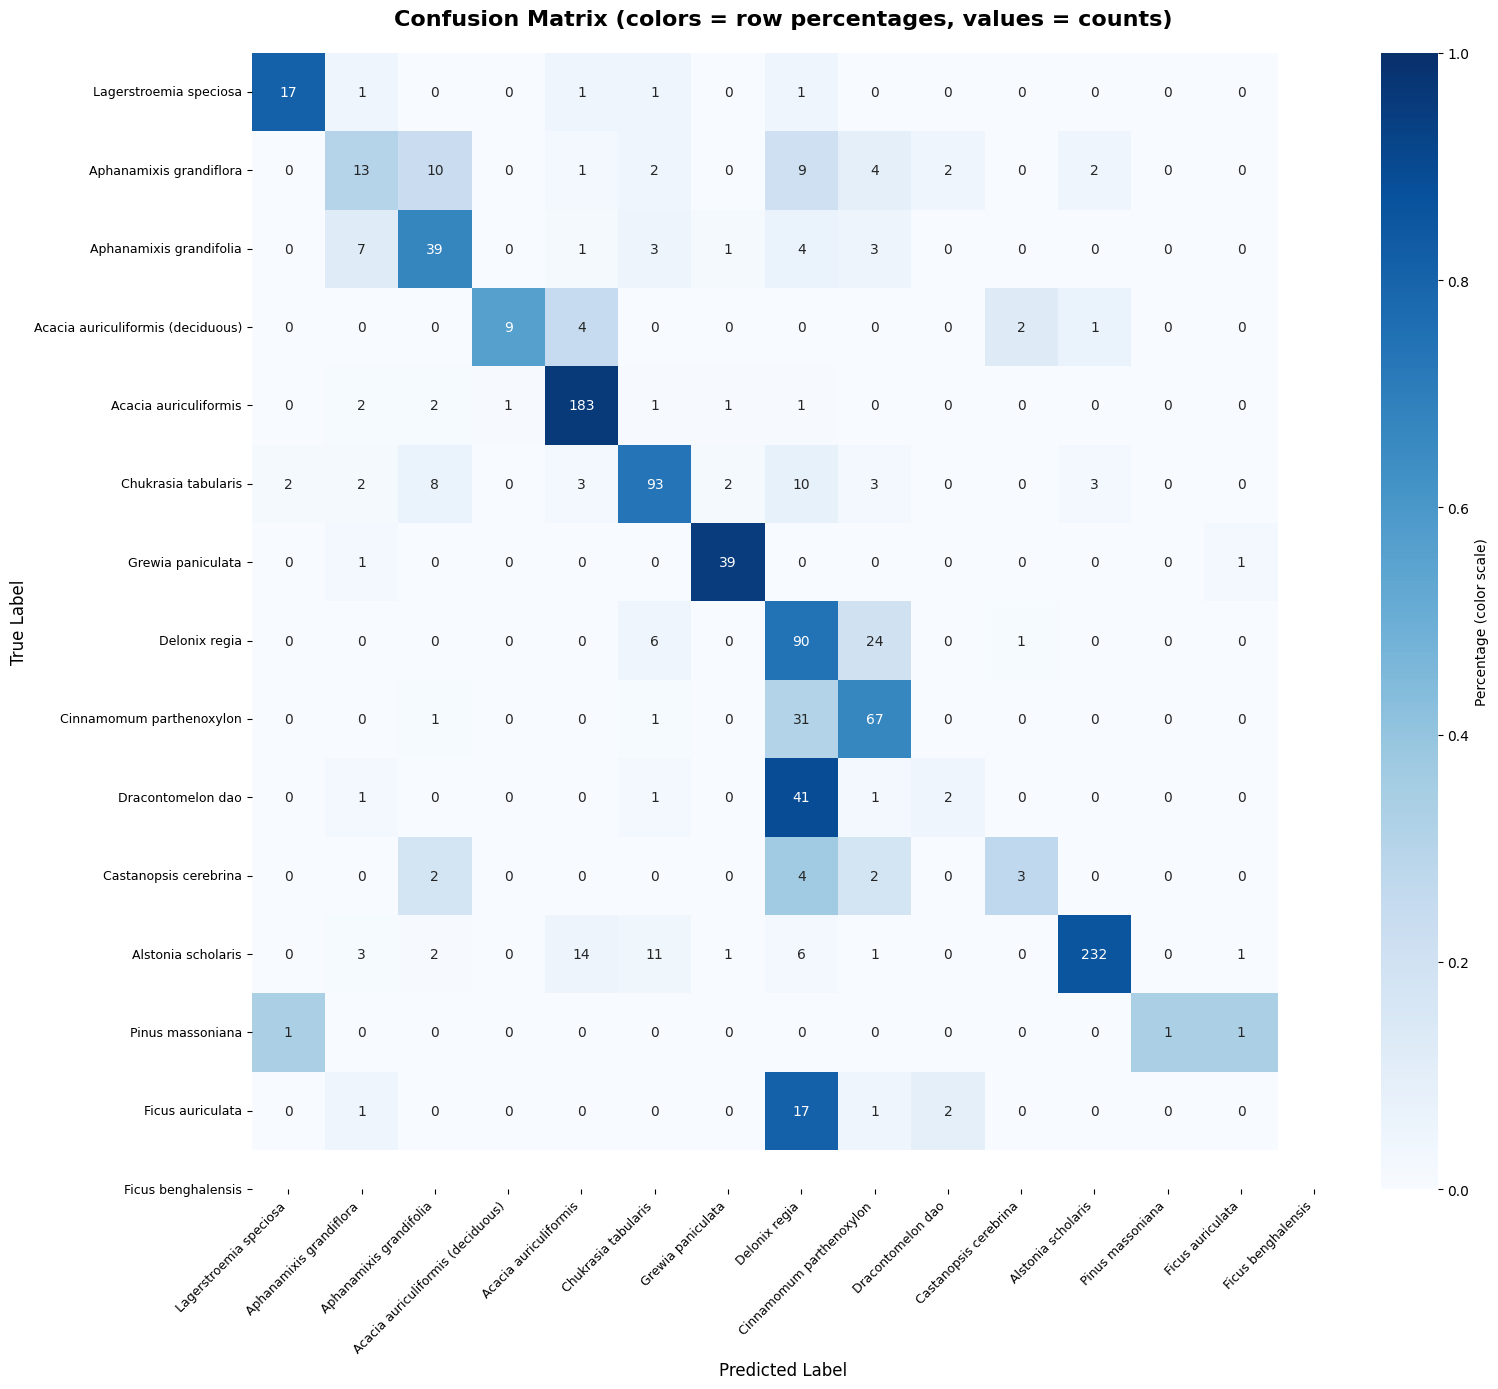

📊 Confusion matrix saved to test_confusion_matrix_global.png


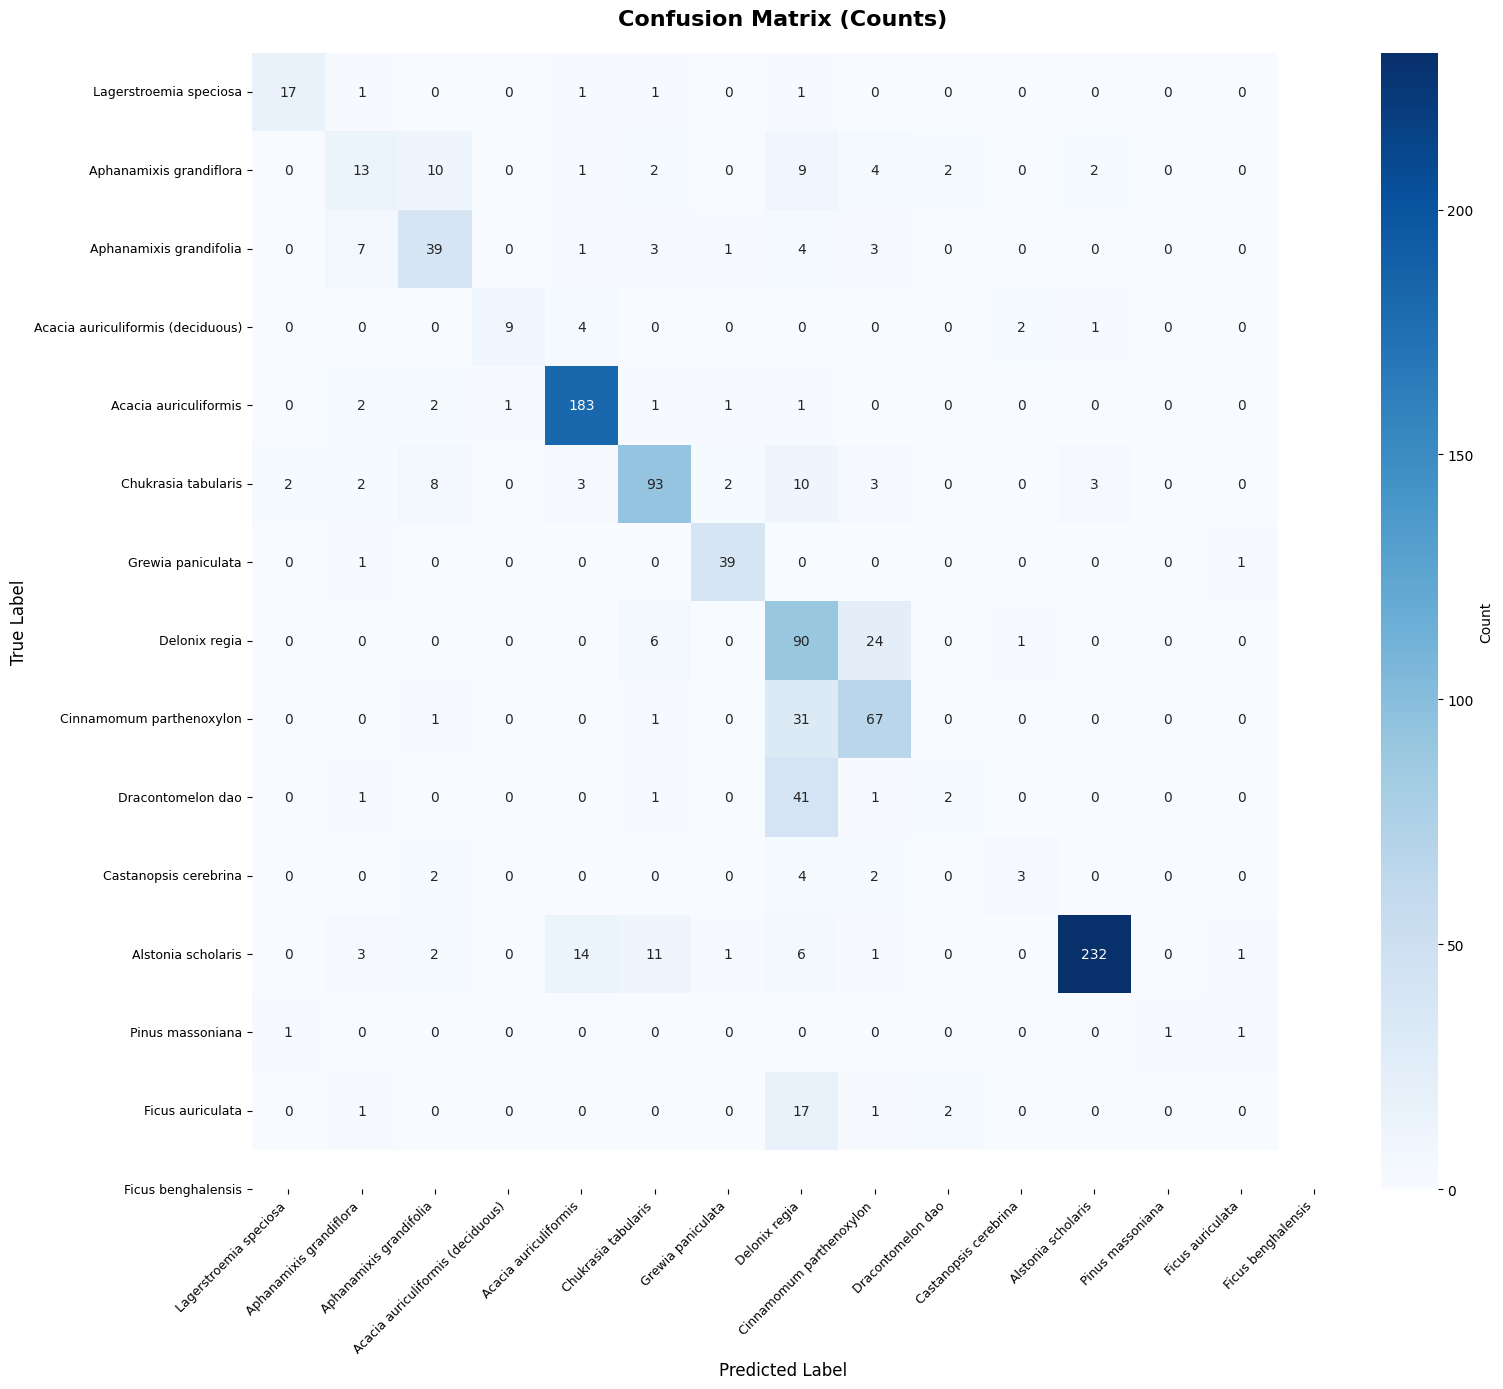


🎉 FINAL TEST RESULTS:
   Accuracy: 73.71%
   Precision: 65.65%
   Recall: 56.53%
   F1-Score: 58.13%


{'test_accuracy': 73.71375116931712,
 'test_precision': 65.65302514136576,
 'test_recall': 56.52587284476701,
 'test_f1_score': 58.12824856858302,
 'per_class_metrics': {'Bằng lăng': {'precision': 85.0,
   'recall': 80.95238095238095,
   'f1_score': 82.92682926829268,
   'support': 21},
  'Gội': {'precision': 41.935483870967744,
   'recall': 30.23255813953488,
   'f1_score': 35.13513513513514,
   'support': 43},
  'Gội trắng': {'precision': 60.9375,
   'recall': 67.24137931034483,
   'f1_score': 63.934426229508205,
   'support': 58},
  'Keo Lá Tràm ( Rụng Lá)': {'precision': 90.0,
   'recall': 56.25,
   'f1_score': 69.23076923076923,
   'support': 16},
  'Keo lá tràm': {'precision': 88.40579710144928,
   'recall': 95.81151832460732,
   'f1_score': 91.95979899497488,
   'support': 191},
  'Lát Hoa': {'precision': 78.15126050420169,
   'recall': 73.80952380952381,
   'f1_score': 75.91836734693878,
   'support': 126},
  'Phượng vĩ': {'precision': 88.63636363636364,
   'recall': 95.1219512

In [25]:
TEST_DIR = "/content/Single/test"

# 2. Cell này dùng để Test riêng biệt
print("Running Testing Step...")

# Sử dụng model đã lưu từ lần train trước
model_path = f"Single_best_{DEFAULT_CONFIG['model_name']}.pth"
# model_path = "/content/drive/MyDrive/2026_ICCE/inception_v4/Single_best_inception_v4.pth"

# Chạy test
run_testing(model_path)

**1) VỚI TỆP 22/05**

Running Testing Step...
🚀 Starting Testing Process using model: Single_best_inception_v4.pth...
Number of classes: 14
Class names: ['Bằng lăng', 'Gội', 'Gội trắng', 'Keo Lá Tràm ( Rụng Lá)', 'Keo lá tràm', 'Lát Hoa', 'Phượng vĩ', 'Re hương', 'Sấu', 'Sồi Phảng', 'Sữa', 'Thông mã vĩ', 'Vả', 'Đa']
Number of train images: 15743
Number of validation images: 1652
Number of test images: 633
Using Focal Loss (alpha=1.0, gamma=2.0)
Model: inception_v4
Device: cuda
Number of parameters: 41,164,334
Loading model from Single_best_inception_v4.pth

🧪 EVALUATING ON TEST SET


Testing: 100%|██████████| 20/20 [00:01<00:00, 16.73it/s, Loss=6.6405, Acc=39.65%]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric


🎯 DETAILED TEST RESULTS
Overall Accuracy: 39.65%
Overall Precision (Macro): 27.06%
Overall Recall (Macro): 16.98%
Overall F1-Score (Macro): 17.27%

📊 PER-CLASS METRICS:
----------------------------------------------------------------------
Class                Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
Bằng lăng            50.00      % 14.29      % 22.22      % 7         
Gội                  23.91      % 25.00      % 24.44      % 44        
Gội trắng            13.98      % 28.89      % 18.84      % 45        
Keo Lá Tràm ( Rụng Lá) 0.00       % 0.00       % 0.00       % 11        
Keo lá tràm          45.83      % 79.04      % 58.02      % 167       
Lát Hoa              40.00      % 7.84       % 13.11      % 51        
Phượng vĩ            69.07      % 46.85      % 55.83      % 143       
Re hương             36.07      % 24.72      % 29.33      % 89        
Sấu                  0.00       % 0.00       % 

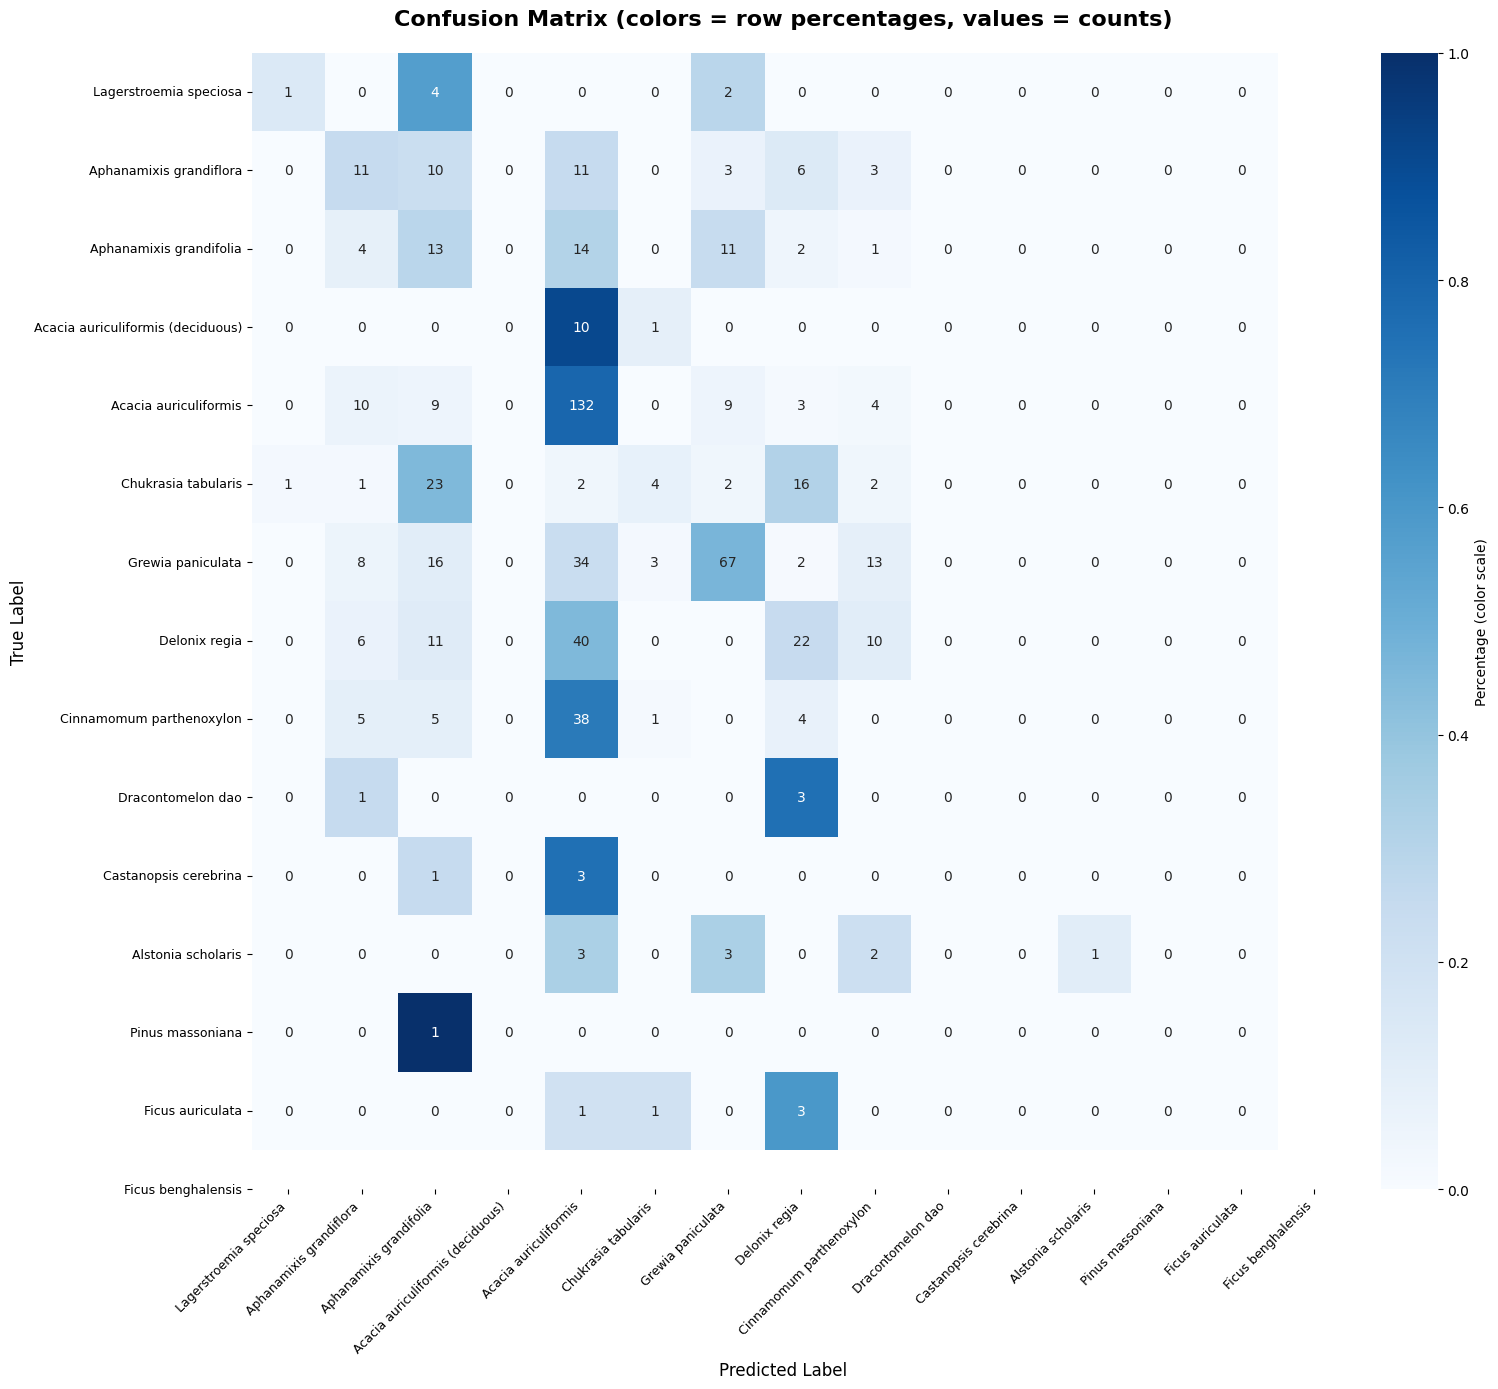

📊 Confusion matrix saved to test_confusion_matrix_global.png


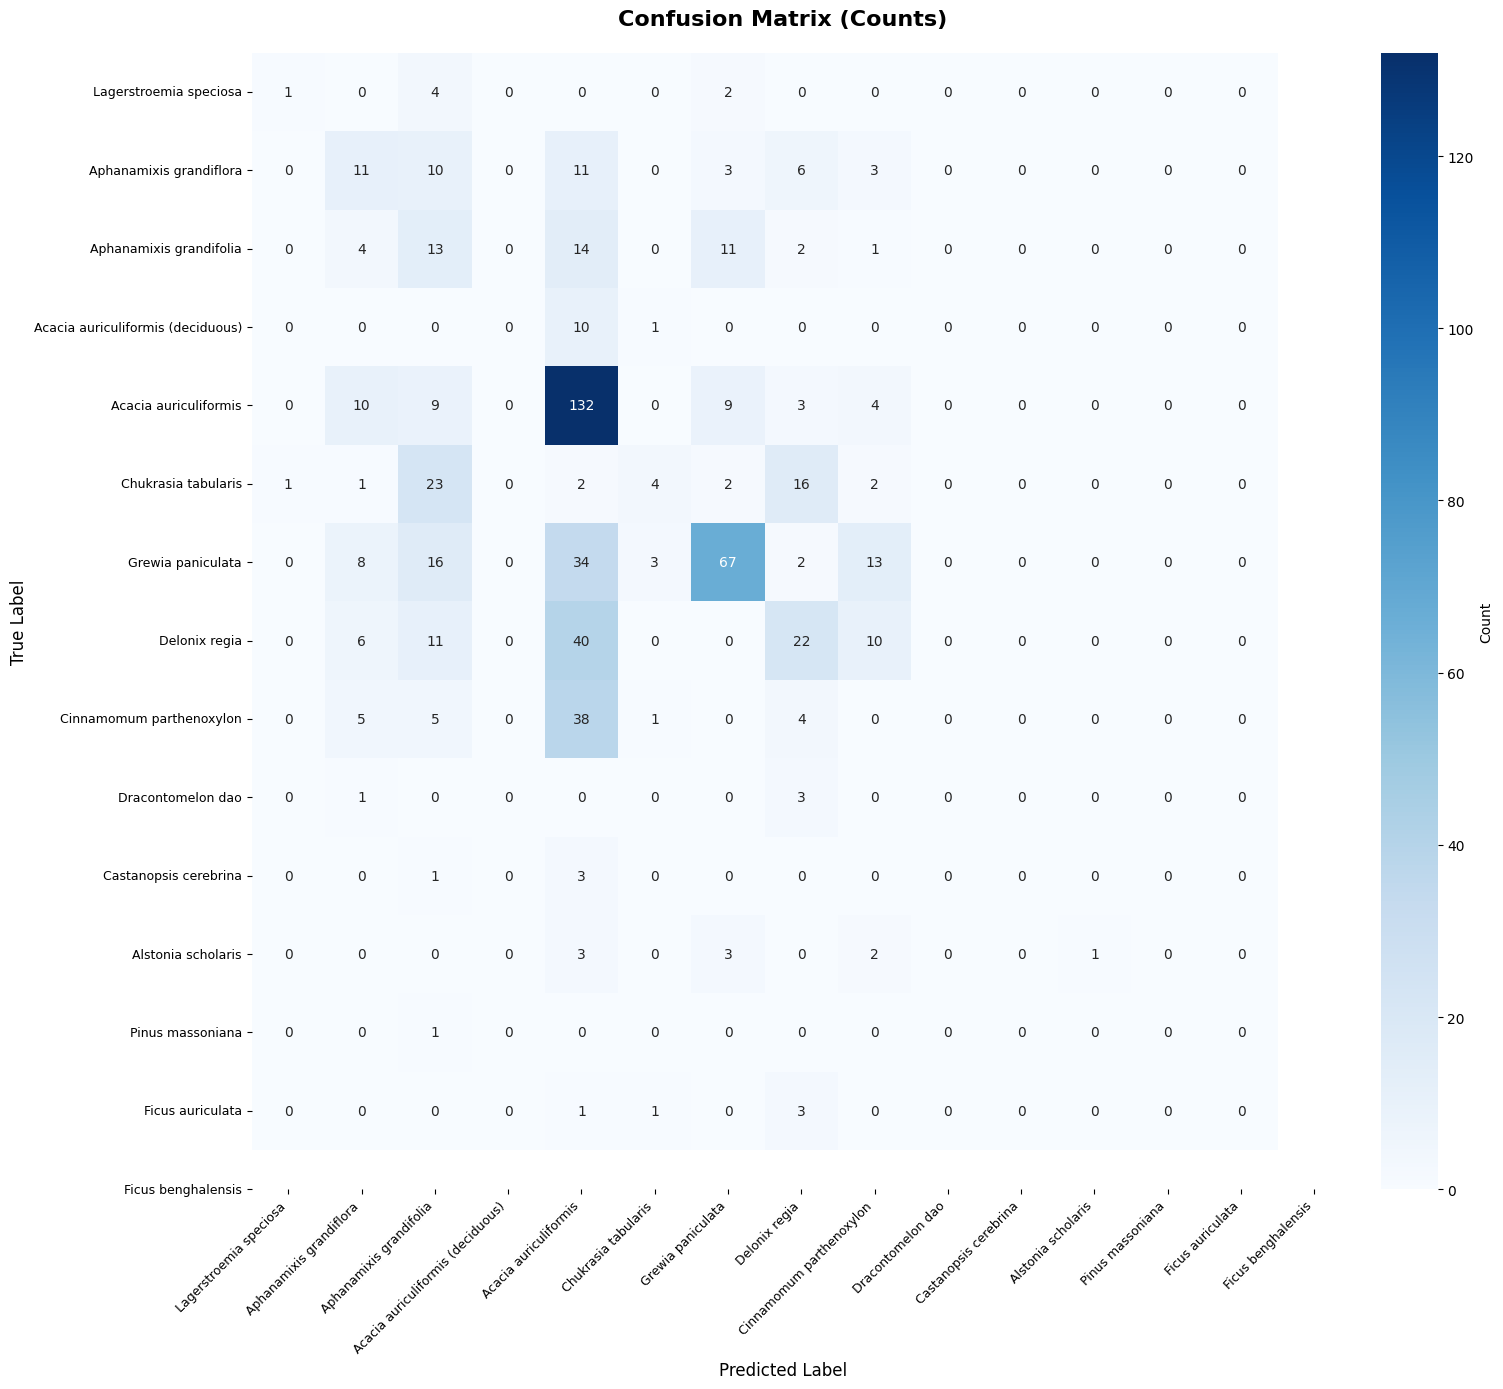


🎉 FINAL TEST RESULTS:
   Accuracy: 39.65%
   Precision: 27.06%
   Recall: 16.98%
   F1-Score: 17.27%


{'test_accuracy': 39.652448657187996,
 'test_precision': 27.061615011013966,
 'test_recall': 16.981643977501662,
 'test_f1_score': 17.272188940272642,
 'per_class_metrics': {'Bằng lăng': {'precision': 50.0,
   'recall': 14.285714285714285,
   'f1_score': 22.22222222222222,
   'support': 7},
  'Gội': {'precision': 23.91304347826087,
   'recall': 25.0,
   'f1_score': 24.444444444444443,
   'support': 44},
  'Gội trắng': {'precision': 13.978494623655912,
   'recall': 28.888888888888886,
   'f1_score': 18.84057971014493,
   'support': 45},
  'Keo Lá Tràm ( Rụng Lá)': {'precision': 0.0,
   'recall': 0.0,
   'f1_score': 0.0,
   'support': 11},
  'Keo lá tràm': {'precision': 45.83333333333333,
   'recall': 79.04191616766467,
   'f1_score': 58.02197802197803,
   'support': 167},
  'Lát Hoa': {'precision': 40.0,
   'recall': 7.8431372549019605,
   'f1_score': 13.114754098360656,
   'support': 51},
  'Phượng vĩ': {'precision': 69.0721649484536,
   'recall': 46.85314685314685,
   'f1_score': 55.8

In [26]:
TEST_DIR = "/content/VNUF_134_Patches"

# 2. Cell này dùng để Test riêng biệt
print("Running Testing Step...")

# Sử dụng model đã lưu từ lần train trước
model_path = f"Single_best_{DEFAULT_CONFIG['model_name']}.pth"
# model_path = "/content/drive/MyDrive/2026_ICCE/inception_v4/Single_best_inception_v4.pth"

# Chạy test
run_testing(model_path)

**2) VỚI TỆP 10/08**

Running Testing Step...
🚀 Starting Testing Process using model: Single_best_inception_v4.pth...
Number of classes: 14
Class names: ['Bằng lăng', 'Gội', 'Gội trắng', 'Keo Lá Tràm ( Rụng Lá)', 'Keo lá tràm', 'Lát Hoa', 'Phượng vĩ', 'Re hương', 'Sấu', 'Sồi Phảng', 'Sữa', 'Thông mã vĩ', 'Vả', 'Đa']
Number of train images: 15743
Number of validation images: 1652
Number of test images: 2368
Using Focal Loss (alpha=1.0, gamma=2.0)
Model: inception_v4
Device: cuda
Number of parameters: 41,164,334
Loading model from Single_best_inception_v4.pth

🧪 EVALUATING ON TEST SET


Testing: 100%|██████████| 74/74 [00:03<00:00, 20.85it/s, Loss=8.2042, Acc=46.96%]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric


🎯 DETAILED TEST RESULTS
Overall Accuracy: 46.96%
Overall Precision (Macro): 32.77%
Overall Recall (Macro): 31.40%
Overall F1-Score (Macro): 28.89%

📊 PER-CLASS METRICS:
----------------------------------------------------------------------
Class                Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
Bằng lăng            34.62      % 29.03      % 31.58      % 31        
Gội                  30.00      % 33.33      % 31.58      % 117       
Gội trắng            23.13      % 58.68      % 33.18      % 121       
Keo Lá Tràm ( Rụng Lá) 64.71      % 91.67      % 75.86      % 24        
Keo lá tràm          88.28      % 69.87      % 78.00      % 604       
Lát Hoa              22.87      % 28.92      % 25.54      % 204       
Phượng vĩ            46.34      % 11.05      % 17.84      % 172       
Re hương             35.25      % 72.12      % 47.36      % 416       
Sấu                  20.00      % 3.98       % 

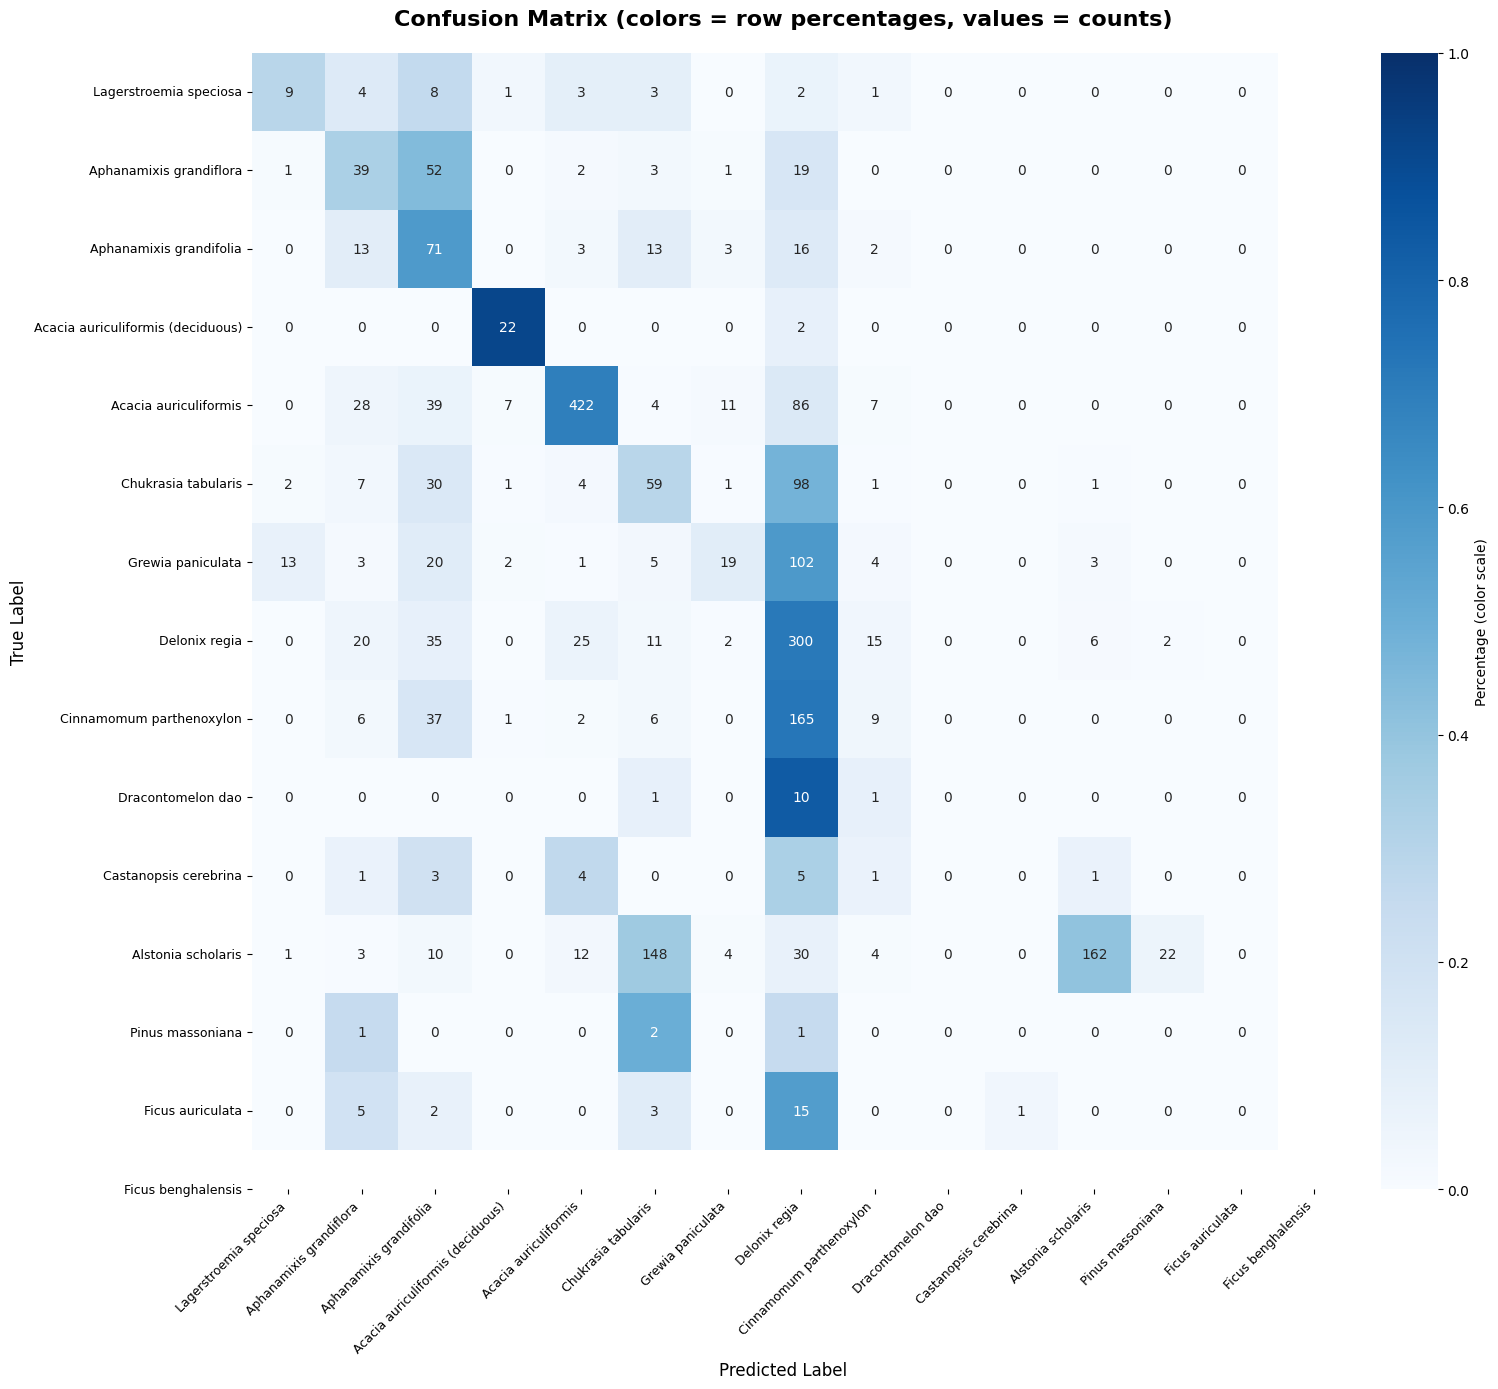

📊 Confusion matrix saved to test_confusion_matrix_global.png


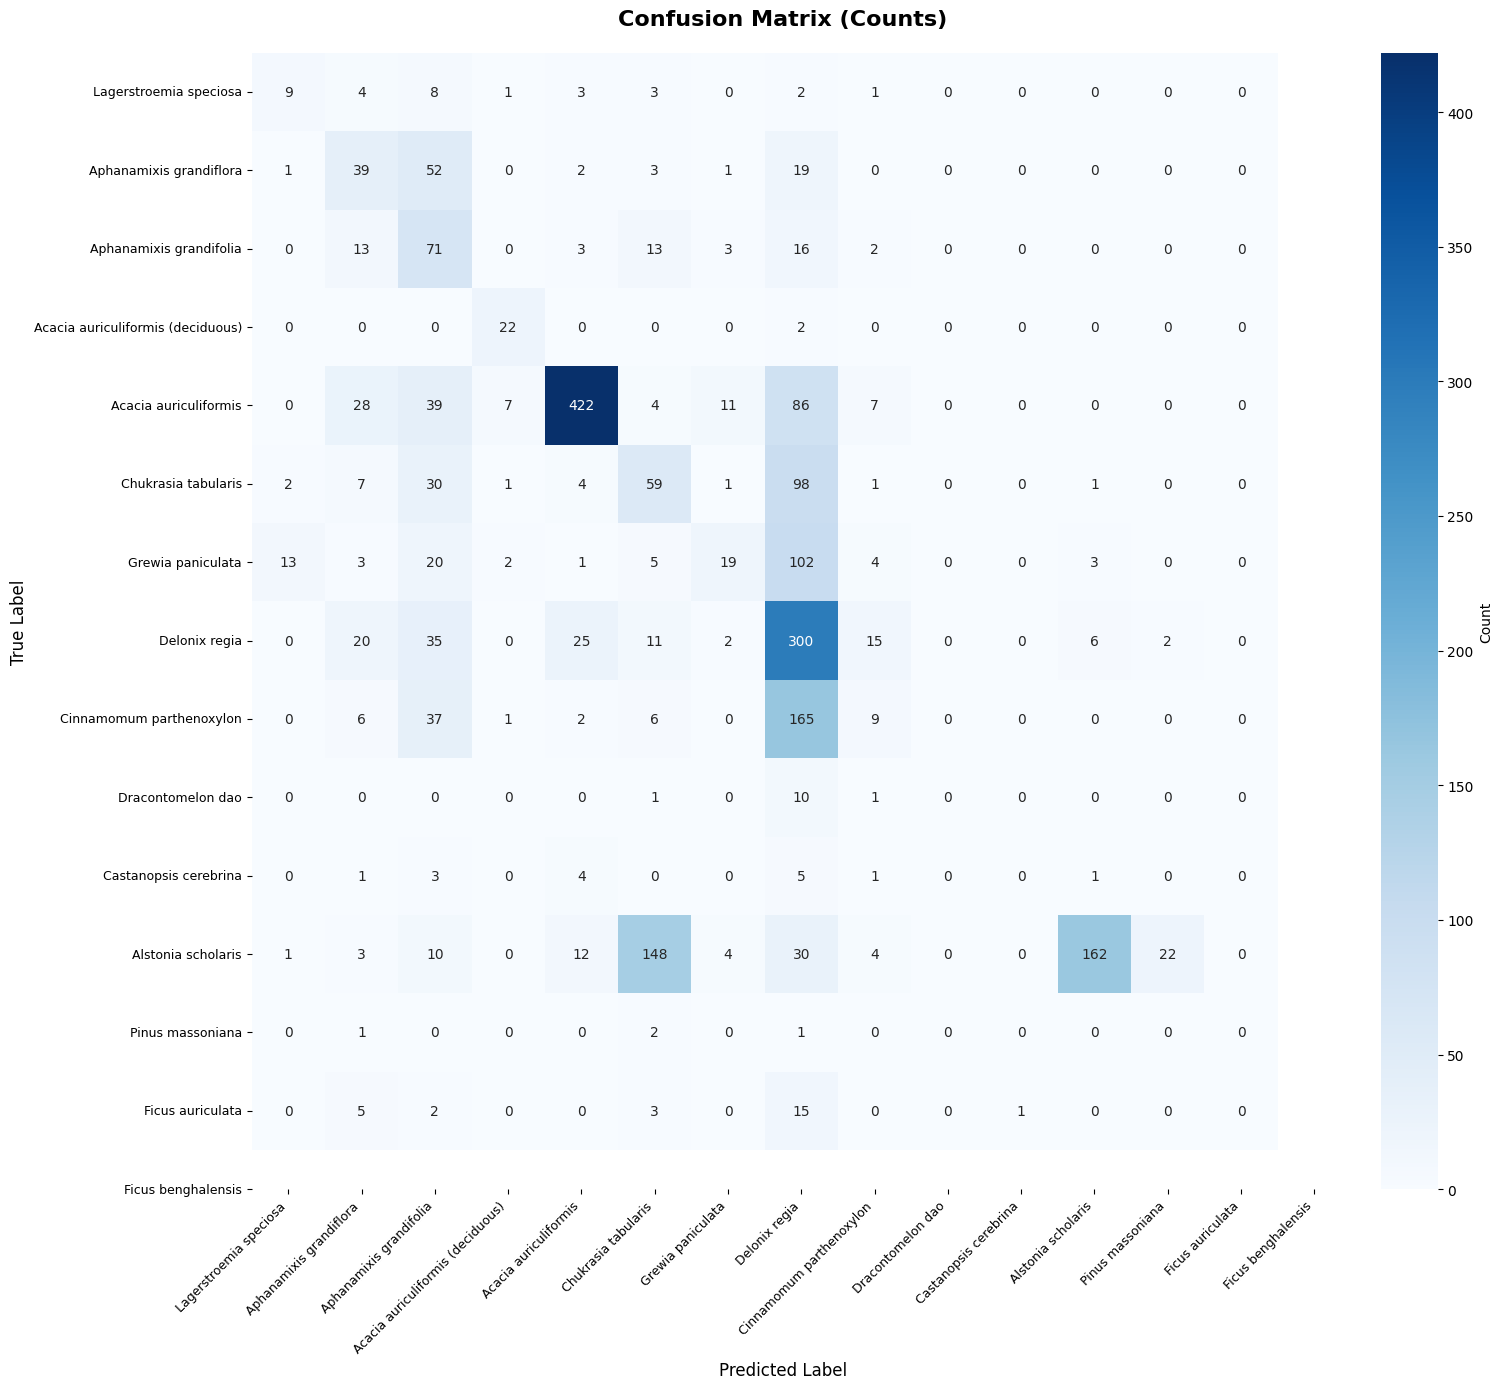


🎉 FINAL TEST RESULTS:
   Accuracy: 46.96%
   Precision: 32.77%
   Recall: 31.40%
   F1-Score: 28.89%


{'test_accuracy': 46.95945945945946,
 'test_precision': 32.774054610121446,
 'test_recall': 31.39659645347091,
 'test_f1_score': 28.89448290537428,
 'per_class_metrics': {'Bằng lăng': {'precision': 34.61538461538461,
   'recall': 29.03225806451613,
   'f1_score': 31.57894736842105,
   'support': 31},
  'Gội': {'precision': 30.0,
   'recall': 33.33333333333333,
   'f1_score': 31.57894736842105,
   'support': 117},
  'Gội trắng': {'precision': 23.12703583061889,
   'recall': 58.67768595041323,
   'f1_score': 33.177570093457945,
   'support': 121},
  'Keo Lá Tràm ( Rụng Lá)': {'precision': 64.70588235294117,
   'recall': 91.66666666666666,
   'f1_score': 75.86206896551724,
   'support': 24},
  'Keo lá tràm': {'precision': 88.28451882845188,
   'recall': 69.86754966887418,
   'f1_score': 78.00369685767097,
   'support': 604},
  'Lát Hoa': {'precision': 22.868217054263564,
   'recall': 28.921568627450984,
   'f1_score': 25.541125541125542,
   'support': 204},
  'Phượng vĩ': {'precision': 46

In [27]:
TEST_DIR = "/content/VNUF_234_Patches"
# 2. Cell này dùng để Test riêng biệt
print("Running Testing Step...")

# Sử dụng model đã lưu từ lần train trước
model_path = f"Single_best_{DEFAULT_CONFIG['model_name']}.pth"
# model_path = "/content/drive/MyDrive/2026_ICCE/inception_v4/Single_best_inception_v4.pth"

# Chạy test
run_testing(model_path)

**3) VỚI TỆP 24/08 CAMERA 1X**

Running Testing Step...
🚀 Starting Testing Process using model: Single_best_inception_v4.pth...
Number of classes: 14
Class names: ['Bằng lăng', 'Gội', 'Gội trắng', 'Keo Lá Tràm ( Rụng Lá)', 'Keo lá tràm', 'Lát Hoa', 'Phượng vĩ', 'Re hương', 'Sấu', 'Sồi Phảng', 'Sữa', 'Thông mã vĩ', 'Vả', 'Đa']
Number of train images: 15743
Number of validation images: 1652
Number of test images: 7378
Using Focal Loss (alpha=1.0, gamma=2.0)
Model: inception_v4
Device: cuda
Number of parameters: 41,164,334
Loading model from Single_best_inception_v4.pth

🧪 EVALUATING ON TEST SET


Testing: 100%|██████████| 231/231 [00:10<00:00, 21.95it/s, Loss=8.1940, Acc=69.56%]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr


🎯 DETAILED TEST RESULTS
Overall Accuracy: 69.56%
Overall Precision (Macro): 51.95%
Overall Recall (Macro): 47.08%
Overall F1-Score (Macro): 46.91%

📊 PER-CLASS METRICS:
----------------------------------------------------------------------
Class                Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
Bằng lăng            69.32      % 57.01      % 62.56      % 107       
Gội                  58.60      % 27.66      % 37.59      % 394       
Gội trắng            39.84      % 75.13      % 52.06      % 386       
Keo Lá Tràm ( Rụng Lá) 77.38      % 70.65      % 73.86      % 92        
Keo lá tràm          86.75      % 89.45      % 88.08      % 1669      
Lát Hoa              76.99      % 75.74      % 76.36      % 676       
Phượng vĩ            91.86      % 73.83      % 81.86      % 596       
Re hương             47.07      % 81.50      % 59.68      % 1184      
Sấu                  55.49      % 12.21      % 

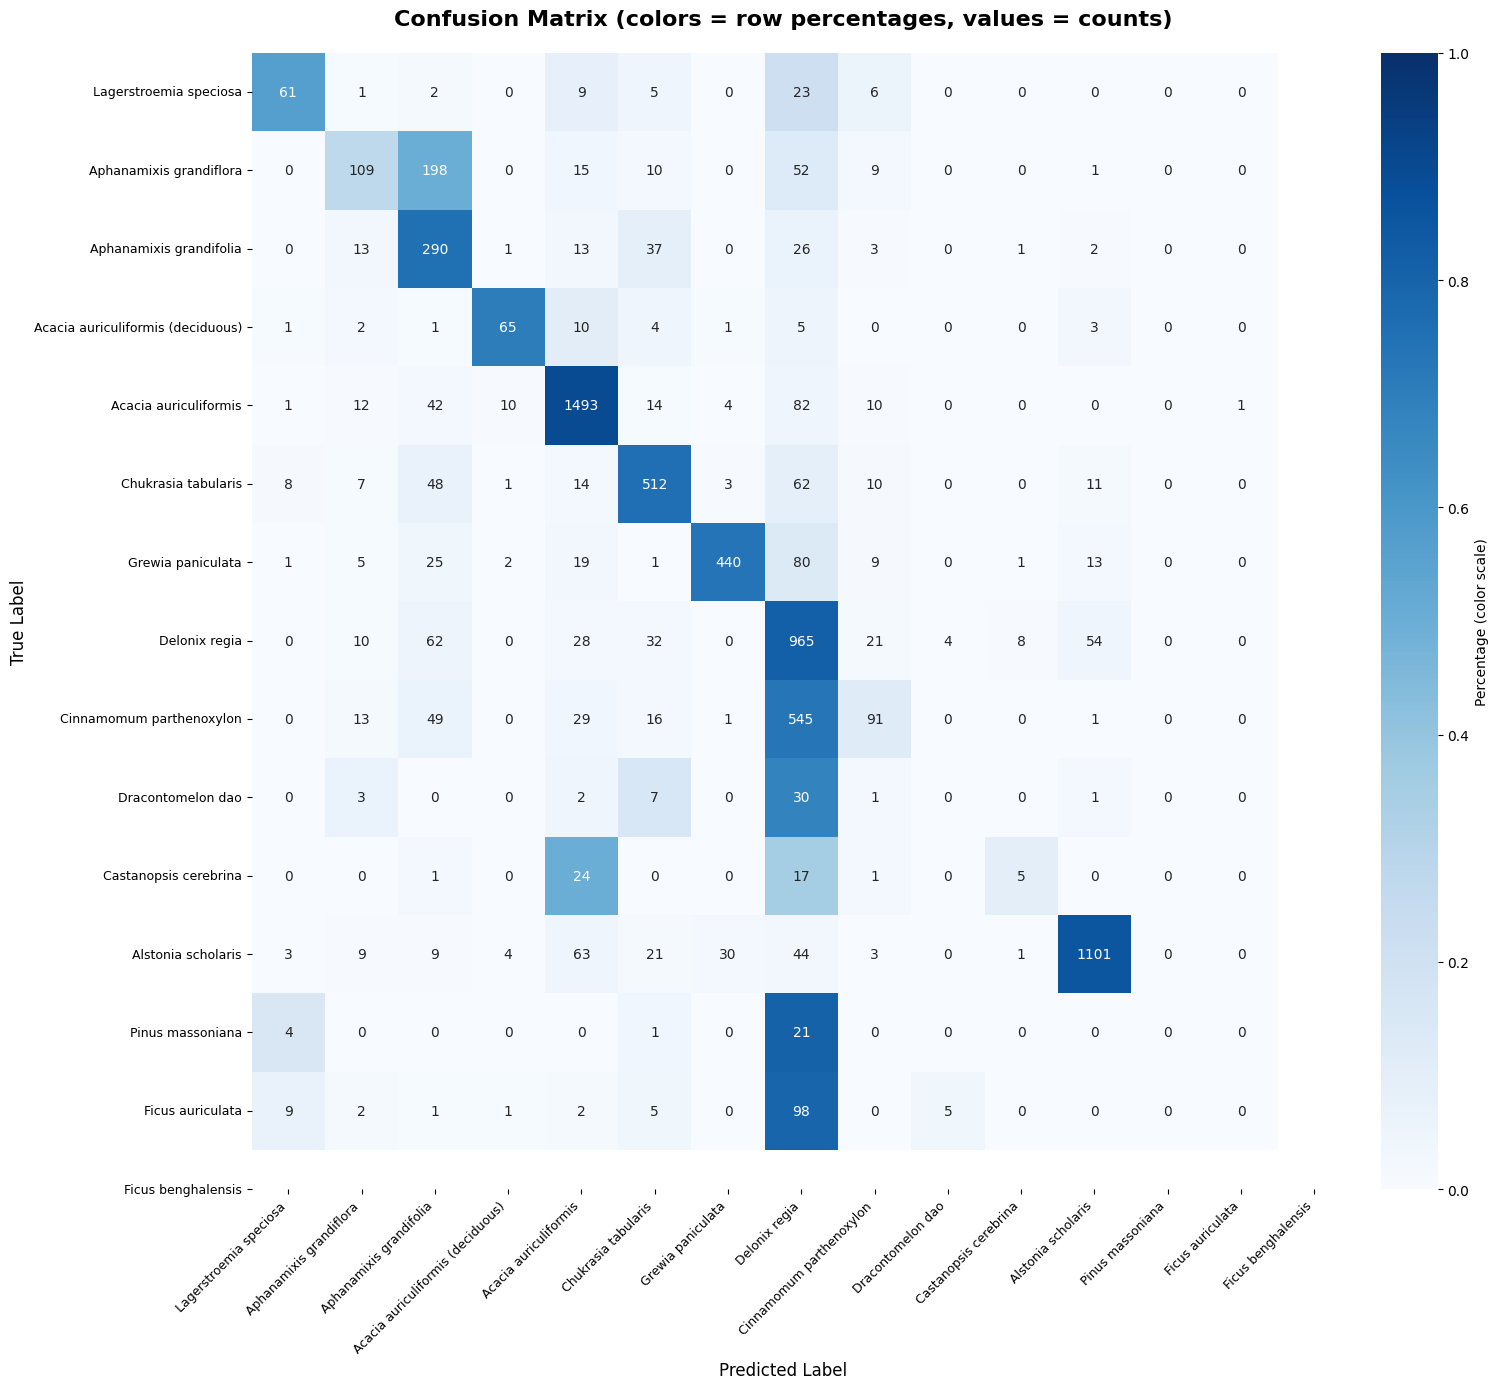

📊 Confusion matrix saved to test_confusion_matrix_global.png


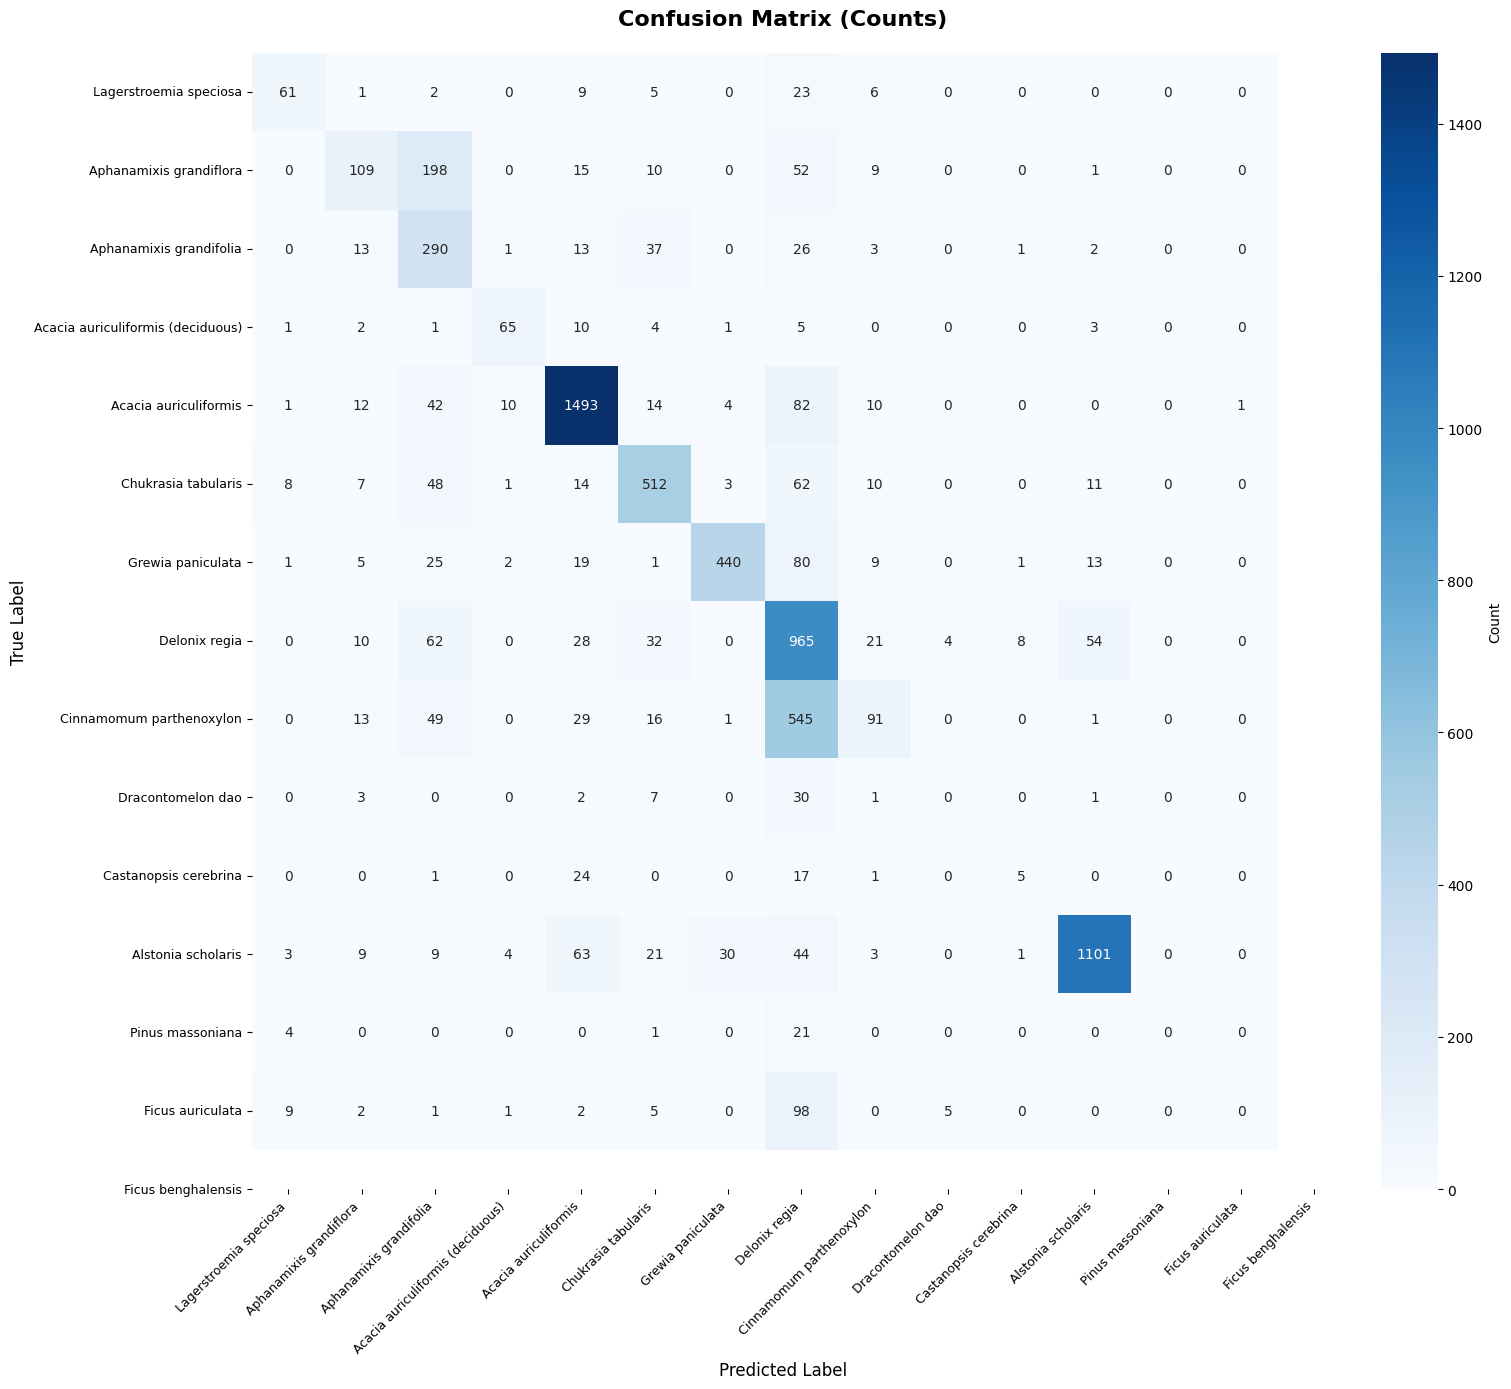


🎉 FINAL TEST RESULTS:
   Accuracy: 69.56%
   Precision: 51.95%
   Recall: 47.08%
   F1-Score: 46.91%


{'test_accuracy': 69.55814583898075,
 'test_precision': 51.95033403891739,
 'test_recall': 47.07800830487717,
 'test_f1_score': 46.90554853156796,
 'per_class_metrics': {'Bằng lăng': {'precision': 69.31818181818183,
   'recall': 57.009345794392516,
   'f1_score': 62.56410256410256,
   'support': 107},
  'Gội': {'precision': 58.602150537634415,
   'recall': 27.66497461928934,
   'f1_score': 37.58620689655172,
   'support': 394},
  'Gội trắng': {'precision': 39.83516483516483,
   'recall': 75.12953367875647,
   'f1_score': 52.06463195691203,
   'support': 386},
  'Keo Lá Tràm ( Rụng Lá)': {'precision': 77.38095238095238,
   'recall': 70.65217391304348,
   'f1_score': 73.86363636363636,
   'support': 92},
  'Keo lá tràm': {'precision': 86.75188843695526,
   'recall': 89.45476333133612,
   'f1_score': 88.08259587020649,
   'support': 1669},
  'Lát Hoa': {'precision': 76.99248120300753,
   'recall': 75.7396449704142,
   'f1_score': 76.36092468307233,
   'support': 676},
  'Phượng vĩ': {'pre

In [28]:
TEST_DIR = "/content/VNUF_299_Patches"
# 2. Cell này dùng để Test riêng biệt
print("Running Testing Step...")

# Sử dụng model đã lưu từ lần train trước
model_path = f"Single_best_{DEFAULT_CONFIG['model_name']}.pth"
# model_path = "/content/drive/MyDrive/2026_ICCE/inception_v4/Single_best_inception_v4.pth"

# Chạy test
run_testing(model_path)

In [29]:
!mkdir /content/drive/MyDrive/2026_ICCE/inception_v4

In [30]:
!mv /content/Single_best_inception_v4.pth /content/drive/MyDrive/2026_ICCE/inception_v4